# T035 · SMILES based property prediction

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Azat Tagirdzhanov, 2022, Saarland University

## Aim of this talktorial

Molecular representation by a SMILES string paved the way for applying natural language processing techniques to a broad range of molecule related tasks. In this talktorial we will dive deeper into one of these techinques: recurrent neural networks (RNNs). First, we will describe different RNN architectures and then apply them to a regression task using the QM9 dataset.

### Contents in *Theory*

* Molecules as text
    * Tokenization and one-hot encoding
* Recurrent Neural Networks (RNNs)
    * Vanilla RNN
    * Training an RNN
    * Vanishing gradients
    * Gated Recurrent Unit

### Contents in *Practical*

* Dataset
* Model definition
* Training
* Evaluation

### References

#### Talktorials
* [__Talktorial T021__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T021_one_hot_encoding/talktorial.ipynb): One-Hot Encoding
* [__Talktorial T022__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T022_ligand_based_screening_neural_network/talktorial.ipynb): Ligand-based screening: neural networks
* __Talktorial T033__: Molecular Representations
* __Talktorial T034__: GNN based property prediction


#### Theoretical background
* Michael Phi, <i>Illustrated Guide to Recurrent Neural Networks</i>, [towardsdatascience](https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9)
* Michael Phi, <i>Illustrated Guide to LSTM’s and GRU’s: A step by step explanation</i>, [towardsdatascience](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)
* [Modern Recurrent Neural Networks](https://d2l.ai/chapter_recurrent-modern/index.html), <i>D2L.ai: Interactive Deep Learning Book with Multi-Framework Code, Math, and Discussions</i>
* Denny Britz, <i>Recurrent Neural Networks Tutorial</i>, [dennybritz.com](https://dennybritz.com/posts/wildml/recurrent-neural-networks-tutorial-part-1/)
* Andrej Karpathy, <i>The Unreasonable Effectiveness of Recurrent Neural Networks</i>, [Andrej Karpathy blog](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)

## Theory

### Molecules as text

To apply machine learning to molecular data, it is necessary to first convert the molecules into a representation that can be used as input to the machine learning models. We have already discussed numerous ways of molecular representations in __Talktorial T033__. In this talktorial we will be using a textual representation of molecules by SMILES strings.

The string representation of molecules paves the way for applying natural language processing (NLP) techniques to molecular data. In recent years, there has been significant progress in NLP models including, most famously, recurrent neural networks and transformers. These models proved to be good at capturing text semantics and, when applied to SMILES strings, can capture the structure of the molecule in its text representation.

#### Tokenization and one-hot encoding

As other machine learning models, NLP models are designed to operate with numeric inputs. We have already discussed how to transform SMILES strings into numerical form in [__Talktorial T021__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T021_one_hot_encoding/talktorial.ipynb). Here, we will only briefly go through the key steps:

- In order to transform a string to a sequence of vectors, the string is first split into meaningful chunks called *tokens*. For example, one way of tokenizing a SMILES string `C=CCl` is to split it into individual atomic and branch symbols: `[C, =, C, Cl]`. 
- All possible tokens form a *vocabulary*. The vocabulary is usually derived from the dataset and contains a fixed amount of most common tokens among all the data. Depending on the application, the vocabulary might also contain special tokens marking out-of-vocabulary tokens, padding symbols, and more. In our example, only limited to this particular compound, the vocabulary will look like `[C, Cl, =]`. Replacing the tokens with their indices in the vocabulary gets us to another representation, `[0, 2, 0, 1]`. 
- Finally, the sequence of token indices is transformed to a sequence of binary vectors using one-hot encoding:
$$
\begin{bmatrix} 1 \\ 0 \\ 0 \end{bmatrix},~
\begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix},~
\begin{bmatrix} 1 \\ 0 \\ 0 \end{bmatrix},~
\begin{bmatrix} 0 \\ 1 \\ 0 \end{bmatrix}.
$$

### Recurrent Neural Networks (RNNs)

Recurrent neural networks (RNNs) are designed to handle sequential data. To do so, they introduce the notion of time. Elements of the input sequence are processed one after another, with output of the current time step being passed to the next one as an additional input. This is done by introducing a special type of connection called a *recurrent connection* (hence the name). This architecture allows RNNs to accumulate information about the past and as a result capture dependencies between elements in the sequence.

The figure below illustrates the basic principle of an RNN. An RNN cell has a hidden state vector $h_t$ which is updated at each time step $t$ and is responsible for aggregating the information about the previous elements of the input sequence. The update is performed by combining the input $x_t$ with the hidden state of the previous step $h_{t-1}$, passed to the RNN cell by the recurrent connection (Figure 1, on the left). 

To better visualize how RNN processes sequences of data it is helpful to unfold the network in time (Figure 1, on the right). The RNN is unfolded by duplicating each unit at each time step and sharing the weights and biases across all the units. The unfolded representation shows that RNNs can be viewed as feed-forward neural networks with shared parameters. 

![RNN](images/rnn-unfolded-800.png)

*Figure 1:* 
Two ways of representing a recurrent neural network: compressed (left) and unfolded in time (right). 

The mechanism behind the computation of the hidden state varies depending on the architecture. Examples of RNN architectures include Vanilla RNN, Long Short-Term Memory (LSTM), and Gated Recurrent Units (GRUs).

#### Vanilla RNN

In a Vanilla RNN the hidden state is updated according to the following recurrence relation,

$$h_{t} = \tanh( W x_{t} + U h_{t-1} + b),~~~t=1,2,\dots,L.$$

Here $W$ and $U$ are weight matrices, and $b$ is a bias vector. The initial hidden state $h_0$ is usually seeded as a vector of zeros. Model weights $W$, $U$ and $b$ are are shared between all the time steps.

#### Training an RNN
Similar to other neural networks, RNNs are trained using a backpropagation algorithm. A flavour of the algorithm used in RNNs is called *backpropagation through time* or BPTT for short. BPTT applies backpropagation to the unfolded network to compute the gradient of the loss function with respect to the network weights taking into account parameter sharing.

#### Vanishing gradients

Vanilla RNNs are susceptible to a problem called *vanishing gradients*. This problem occurs in deep neural networks when the gradients of the weights of the first layers of the network become very small as they are backpropagated through the network. This can lead to slow training and poor performance. In RNNs, the backpropagation is applied to the unfolded network which tends to be very deep. Furthermore, all copies of the RNN cells in the unfolded network share the same weights, which can cause gradients to diminish exponentially fast. For more details on the vanishing gradients problem, please refer to the blogpost [Backpropagation Through Time and Vanishing Gradients](https://dennybritz.com/posts/wildml/recurrent-neural-networks-tutorial-part-3/). 

#### Gated Recurrent Unit

Gated recurrent unit (GRU) is a more advanced architecture of the recurrent network that aims to solve the vanishing gradient problem. In addition to the hidden state vector, GRU introduces so-called *update gate* and *reset gate*. These two vectors help the model to decide which information should be passed forward. They can be trained to keep information from long ago, without washing it through time or remove information which is irrelevant to the prediction.


##### Reset gate

This gate is used by the GRU cell to decide how much of the past information to forget. It is calculated using the formula

$$r_t = \sigma(W_{r} x_t + U_{r} h_{t-1} + b_r).$$

The input vector $x_t$ is multiplied by the weight matrix $W_r$. The hidden state from the previous time step $h_{t-1}$ is also plugged into the cell and is multiplied by its own weight matrix $U_r$. Both results are added together with a bias vector $b_r$, and passed through a sigmoid activation function to limit the output to a range between 0 and 1.

##### Update gate

The update gate is calculated using a similar formula,

$$z_t = \sigma(W_{z} x_t + U_{z} h_{t-1} + b_z),$$

but it has its own weights $W_z$, $U_z$, $b_z$, and serves a different purpose. As we will see below, the update gate helps the GRU cell to decide how much of the past information should be passed to the future step.

##### Hidden state candidate

A candidate hidden state stores the relevant information from the past. It is calculated as follows:

$$\hat{h}_t = \tanh(W_{h} x_t + U_{h}(r_t \odot h_{t-1}) + b_h),$$

where $\odot$ is the [element-wise product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) and $r_t$ is the reset gate vector introduced above. This formula looks similar to how the hidden state is updated in a simple RNN cell, but here the hidden state from the previous time step $h_{t-1}$ is multiplied by the reset gate vector $r_t$. Due to sigmoid activation, components of $r_t$ take values between 0 and 1. Using the reset gate the model can learn which information is not relevant and should be discarded. If, for example, an $i$-th component of $r_t$ is close to 0, then the memory contained in the $i$-th component of $h_{t-1}$ will be discarded in the candidate vector. 

##### Hidden state update

Finally, the hidden state is updated as a mixture of $h_{t-1}$ and the hidden state candidate,

$$h_t =   z_t \odot h_{t-1} + (1-z_t) \odot  \hat{h}_t. $$

Here, the update gate vector $z_t$ controls how much of information to collect from the candidate vector $\hat{h}_t$ and and how much from the previous steps $h_{t-1}$.



## Practical

In the practical section we will apply recurrent neural networks to a regression task.  

In [1]:
import os
import re
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset

In [3]:
# use cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# seed random generator
_ = torch.manual_seed(42)

In [4]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Dataset

In this talktorial we use [QM9](https://pytorch-geometric.readthedocs.io/en/2.2.0/modules/datasets.html#torch_geometric.datasets.QM9) dataset from the [MoleculeNet](https://arxiv.org/abs/1703.00564) paper. This dataset consists of about 130,000 molecules together with their quantum chemical properties. 

In [5]:
# load the dataset
df = pd.read_csv(os.path.join(DATA, 'qm9.csv.gz'), compression='gzip')
df.head()

,mol_id,A,B,C,mu,alpha,homo,lumo,gap,r2,...,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom,smiles
0,gdb_1,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,...,-40.478930,-40.476062,-40.475117,-40.498597,6.469,-395.999595,-398.643290,-401.014647,-372.471772,C
1,gdb_2,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,26.1563,...,-56.525887,-56.523026,-56.522082,-56.544961,6.316,-276.861363,-278.620271,-280.399259,-259.338802,N
2,gdb_3,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,19.0002,...,-76.404702,-76.401867,-76.400922,-76.422349,6.002,-213.087624,-213.974294,-215.159658,-201.407171,O
3,gdb_4,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,59.5248,...,-77.308427,-77.305527,-77.304583,-77.327429,8.574,-385.501997,-387.237686,-389.016047,-365.800724,C#C
4,gdb_5,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,48.7476,...,-93.411888,-93.409370,-93.408425,-93.431246,6.278,-301.820534,-302.906752,-304.091489,-288.720028,C#N


In this talktorial we will build a model predicting one of the properties -- the dipole moment `mu` -- based on the string representation of the molecule provided in the `smiles` column in the table above. 

#### Preprocessing

First, define classes and helper functions we will be using for the data preprocessing

In [6]:
class SmilesTokenizer(object):
    """
    A simple regex-based tokenizer adapted from the deepchem smiles_tokenizer package. 
    SMILES regex pattern for the tokenization is designed by Schwaller et. al., ACS Cent. Sci 5 (2019)
    """
    def __init__(self):
        self.regex_pattern = (r"(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\."
                              r"|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])")
        self.regex = re.compile(self.regex_pattern)        
    
    def tokenize(self, smiles):
        """
        Tokenizes SMILES string.

        Parameters
        ----------
        smiles : str
            Input SMILES string.

        Returns
        -------
        List[str]
            A list of tokens.
        """
        tokens = [token for token in self.regex.findall(smiles)]
        return tokens

In [7]:
def build_vocab(smiles_list, tokenizer, max_vocab_size):
    """
    Builds a vocabulary of N=max_vocab_size most common tokens from list of SMILES strings. 

    Parameters
    ----------
    smiles_list : List[str]
        List of SMILES strings.
    tokenizer : SmilesTokenizer
    max_vocab_size : int
        Maximum size of vocabulary.

    Returns
    -------
    Dict[str, int]
        A dictionary that defines mapping of a token to its index in the vocabulary.
    """
    tokenized_smiles = [tokenizer.tokenize(s) for s in smiles_list]
    token_counter = Counter(c for s in tokenized_smiles for c in s)
    tokens = [token for token, _ in token_counter.most_common(max_vocab_size)] 
    vocab  = {token: idx for idx, token in enumerate(tokens)}
    return vocab


def smiles_to_ohe(smiles, tokenizer, vocab):
    """
    Transforms SMILES string to one-hot encoding representation. 

    Parameters
    ----------
    smiles : str
        Input SMILES string.
    tokenizer : SmilesTokenizer
    vocab : Dict[str, int]
        A dictionary that defines mapping of a token to its index in the vocabulary.

    Returns
    -------
    Tensor
        A pytorch Tensor with shape (n_tokens, vocab_size), where n_tokens is the 
        length of tokenized input string, vocab_size is the number of tokens in 
        the vocabulary 
    """
    unknown_token_id = len(vocab) - 1
    token_ids = [vocab.get(token, unknown_token_id) for token in tokenizer.tokenize(smiles)]
    ohe = torch.eye(len(vocab))[token_ids]
    return ohe

Let's have a look on how this functions work on a simple example. Here, we will be using the same SMILES string as in the Theoretical section.

In [8]:
tokenizer = SmilesTokenizer()

smiles = 'C=CCl'
print('SMILES string:\n\t', smiles)
print('Tokens:\n\t', ', '.join(tokenizer.tokenize(smiles)))
vocab = build_vocab([smiles], tokenizer, 3)
print('Vocab:\n\t', vocab)
print('OHE:\n', np.array(smiles_to_ohe(smiles, tokenizer, vocab)).T)

SMILES string:
	 C=CCl
Tokens:
	 C, =, C, Cl
Vocab:
	 {'C': 0, '=': 1, 'Cl': 2}
OHE:
 [[1. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


Now, we apply these preprocessing steps to our data. For the sake of reducing the runtime, we will be using only a random subset of the whole QM9 dataset. The dataset is split into training, validation and test sets. We build the vocabulary and define transformation of the target based only on training set.

In [9]:
sample_size = 50000
n_train = 40000
n_test = n_val = 5000

# get a sample 
df = df.sample(n=sample_size, axis=0, random_state=42)

# select columns from the dataframe
smiles = df['smiles'].tolist()
y = df['mu'].to_numpy()

# build a vocab using the training data
max_vocab_size = 30
vocab = build_vocab(smiles[:n_train], tokenizer, max_vocab_size)
vocab_size = len(vocab)

# transform smiles to one-hot encoded tensors and apply padding
X = pad_sequence(
    sequences=[smiles_to_ohe(smi, tokenizer, vocab) for smi in smiles], 
    batch_first=True, padding_value=0
)

# normalize the target using the training data
train_mean = y[:n_train].mean()
train_std  = y[:n_train].std()
y = (y - train_mean) / train_std

# build dataset
data = TensorDataset(X, torch.Tensor(y))

# define loaders
ids_train = np.arange(n_train)
ids_val   = np.arange(n_val) + n_train
ids_test  = np.arange(n_test) + n_train + n_val
train_loader = DataLoader(Subset(data, ids_train), batch_size=64, shuffle=True, 
                          generator=torch.Generator().manual_seed(42))
val_loader   = DataLoader(Subset(data, ids_val), batch_size=64, shuffle=True, 
                          generator=torch.Generator().manual_seed(42)) 
test_loader  = DataLoader(Subset(data, ids_test), batch_size=1, shuffle=False, 
                          generator=torch.Generator().manual_seed(42))

### Models

In this talktorial we compare two recurrent networks. Both of them contain a single recurrent layer followed by a fully-connected layer transforming the hidden state from the last time step to a one-dimensional output. In the `RNNRegressionModel` we use a vanilla RNN architecture, while in `GRURegressionModel` a more advanced GRU architecture.

In [10]:
class RNNRegressionModel(nn.Module):
    """Vanilla RNN with one recurrent layer"""
    def __init__(self, input_size, hidden_size=32):
        """
        Vanilla RNN

        Parameters
        ----------
        input_size : int
            The number of expected features in the input vector
        hidden_size : int
            The number of features in the hidden state

        """
        super(RNNRegressionModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(p=.2)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        out, hn = self.rnn(x, h0)
        out = out[:, -1]
        out = self.dropout(out)
        out = self.fc(out)
        return out
    
    
class GRURegressionModel(nn.Module):
    """GRU network with one recurrent layer"""
    def __init__(self, input_size, hidden_size=32):
        """
        GRU network

        Parameters
        ----------
        input_size : int
            The number of expected features in the input vector
        hidden_size : int
            The number of features in the hidden state

        """
        super(GRURegressionModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True) 
        self.fc = nn.Linear(hidden_size, 1)  
        self.dropout = nn.Dropout(p=.2)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        out, hn = self.gru(x, h0)
        out = out[:, -1]
        out = self.dropout(out)
        out = self.fc(out)
        return out

### Training

In [11]:
class ModelTrainer(object):
    """A class that provides training and validation infrastructure for the model and keeps track of training and validation metrics."""
    def __init__(self, model, lr, name=None, clip_gradients=False):
        """
        Initialization.

        Parameters
        ----------
        model : nn.Module
            a model
        lr : float
            learning rate for one training step

        """
        self.model = model
        self.lr = lr
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), self.lr)
        self.clip_gradients = clip_gradients
        self.model.to(device)
        
        self.train_loss = []
        self.batch_loss = []
        self.val_loss  = []
    
    def _train_epoch(self, loader):
        self.model.train()
        epoch_loss = 0
        batch_losses = []
        for i, (X_batch, y_batch) in enumerate(loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            self.optimizer.zero_grad()
            y_pred = self.model(X_batch)
            loss = self.criterion(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            
            if self.clip_gradients:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1, norm_type=2)
            
            self.optimizer.step()
            epoch_loss += loss.item()
            batch_losses.append(loss.item())
        
        return epoch_loss/len(loader), batch_losses
    
    def _eval_epoch(self, loader):
        self.model.eval()
        val_loss = 0
        predictions = []
        targets = []
        with torch.no_grad():
            for X_batch, y_batch in loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = self.model(X_batch)
                loss = self.criterion(y_pred, y_batch.unsqueeze(1))
                val_loss += loss.item()
                predictions.append(y_pred.detach().numpy())
                targets.append(y_batch.unsqueeze(1).detach().numpy())
        
        predictions = np.concatenate(predictions).flatten()
        targets = np.concatenate(targets).flatten()
        return val_loss/len(loader), predictions, targets
    
    def train(self, train_loader, val_loader, n_epochs, print_every=10):
        """
        Train the model

        Parameters
        ----------
        train_loader : 
            a dataloader with training data
        val_loader : 
            a dataloader with training data
        n_epochs :
            number of epochs to train for
        """
        for e in range(n_epochs):
            train_loss, train_loss_batches = self._train_epoch(train_loader)
            val_loss, _, _ = self._eval_epoch(test_loader)
            self.batch_loss += train_loss_batches
            self.train_loss.append(train_loss)
            self.val_loss.append(val_loss)
            if e % print_every == 0:
                print(f'Epoch {e+0:03} | train_loss: {train_loss:.5f} | val_loss: {val_loss:.5f}')
    
    def validate(self, val_loader):
        """
        Validate the model

        Parameters
        ----------
        val_loader : 
            a dataloader with training data
        
        Returns
        -------
        Tuple[list, list, list]
            Loss, y_predicted, y_target for each datapoint in val_loader.
        """
        loss, y_pred, y_targ = self._eval_epoch(val_loader)
        return loss, y_pred, y_targ

Now we define the models and train them for 50 epochs. The hidden state has the same dimension for both models.

In [12]:
model_rnn = ModelTrainer(
    model=RNNRegressionModel(vocab_size, hidden_size=32),
    lr=1e-3,
)

In [13]:
model_rnn.train(train_loader, val_loader, 51)

Epoch 000 | train_loss: 1.00060 | val_loss: 0.93796
Epoch 010 | train_loss: 0.63237 | val_loss: 0.56349
Epoch 020 | train_loss: 0.54434 | val_loss: 0.49586
Epoch 030 | train_loss: 0.51031 | val_loss: 0.47032
Epoch 040 | train_loss: 0.47616 | val_loss: 0.44936
Epoch 050 | train_loss: 0.46097 | val_loss: 0.49712


In [14]:
model_gru = ModelTrainer(
    model=GRURegressionModel(vocab_size, hidden_size=32),
    lr=1e-3,
)

In [15]:
model_gru.train(train_loader, val_loader, 51)

Epoch 000 | train_loss: 0.73387 | val_loss: 0.53829
Epoch 010 | train_loss: 0.43030 | val_loss: 0.40386
Epoch 020 | train_loss: 0.37359 | val_loss: 0.36704
Epoch 030 | train_loss: 0.33639 | val_loss: 0.34342
Epoch 040 | train_loss: 0.31038 | val_loss: 0.32925
Epoch 050 | train_loss: 0.29032 | val_loss: 0.31914


### Evaluation

First, we compare our models performance during training. We have plotted the losses on the training and validation sets on each epoch. As we can see, the GRU model trains faster and has better overall performance compared to the Vanilla RNN.

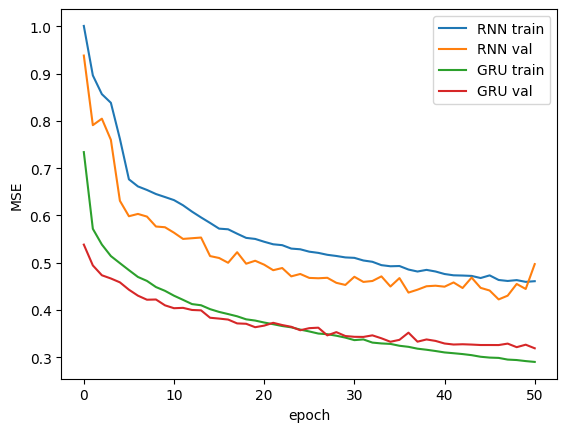

In [16]:
_ = plt.plot(model_rnn.train_loss, label=f'RNN train')
_ = plt.plot(model_rnn.val_loss, label=f'RNN val')
_ = plt.plot(model_gru.train_loss, label=f'GRU train')
_ = plt.plot(model_gru.val_loss, label=f'GRU val')
_ = plt.xlabel('epoch')
_ = plt.ylabel('MSE')
_ = plt.legend()

To further evaluate the performance of the models, we calculate the loss on the testing set and visually compare the predictions to the ground truth values. As we can see from the plot, Vanilla RNN tends to produce more skewed predictions compared to the GRU model. 

RNN test loss: 0.497
GRU test loss: 0.319


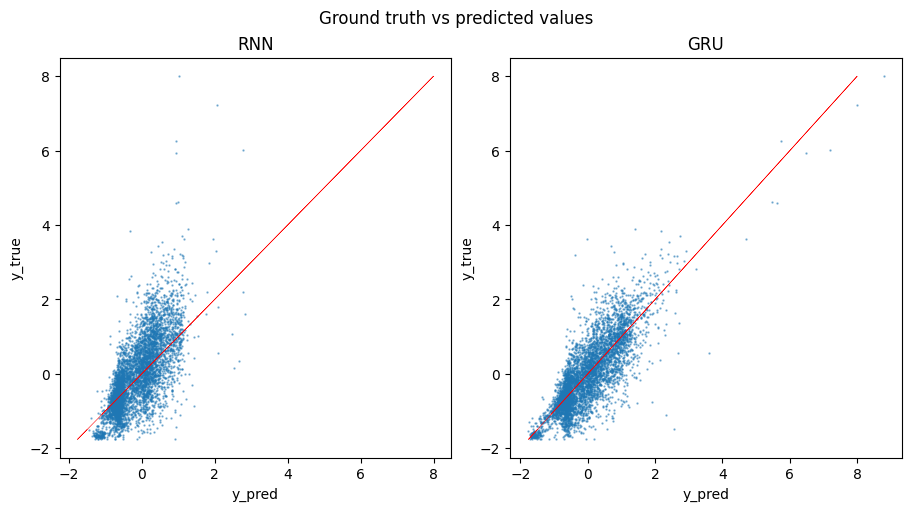

In [17]:
f, axarr = plt.subplots(1, 2, figsize=(9,5), constrained_layout=True)

f.suptitle('Ground truth vs predicted values')

loss, y_pred, y_targ = model_rnn.validate(test_loader)
print(f'RNN test loss: {loss:.3f}')

_ = axarr[0].scatter(y_pred, y_targ, alpha=.5, s=.5)
_ = axarr[0].plot(y_targ, y_targ, lw=.4, c='r')
_ = axarr[0].set_title('RNN')

loss, y_pred, y_targ = model_gru.validate(test_loader)
print(f'GRU test loss: {loss:.3f}')

_ = axarr[1].scatter(y_pred, y_targ, alpha=.5, s=.5)
_ = axarr[1].plot(y_targ, y_targ, lw=.4, c='r')
_ = axarr[1].set_title('GRU')

for ax in axarr:
    _ = ax.set_xlabel('y_pred')
    _ = ax.set_ylabel('y_true')

## Discussion

Natural language processing based models proved to be a powerful tool for a wide range of molecular tasks. In this talktorial we introduced the basics of Recurrent Neural Network architectures and demonstrated their application to the regression task on the QM9 dataset. We have learned how to preprocess SMILES strings, build a model using PyTorch, and train the model to predict the dipole moment of the molecule. 

## Quiz

1. What problems do the recurrent neural networks experience during training?
2. In this talktorial we used a regex-based tokenizer. What other tokenization approaches could be used?
3. Why Gated recurrent unit architecture is better in capturing long-term relations?